Melakukan import library yang akan digunakan dalam project

In [ ]:
from sklearn.datasets import load_files
import numpy as np
import zipfile

Melakukan ektraksi file zip dataset dari google drive setelah itu dimasukan ke dalam file tmp dari library zipfile

In [ ]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/fruits-360new.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

train_dir = '/tmp/fruits-360/Training'
test_dir = '/tmp/fruits-360/Test'
val_dir = '/tmp/fruits-360/Validation'

#fungsi menggabungkan Gambar
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
x_val, y_val,_ = load_dataset(val_dir)

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])
print('Validation set size : ', x_val.shape[0])

Loading complete!
Training set size :  8407
Testing set size :  2812
Validation set size :  2812


Menghitung class yang ada di dalam dataset

In [ ]:
#Hitung class yang ada
no_of_classes = len(np.unique(y_train))
no_of_classes

17

Mengonversi vektor class ke ke matrix biner

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Membagi set validasi menjadi set test dan validasi

In [ ]:
x_test,x_valid = x_test[1406:],x_test[:1406]
y_test,y_vaild = y_test[1406:],y_test[:1406]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_vaild.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Vaildation X :  (1406,)
Vaildation y : (1406, 17)
Test X :  (1406,)
Test y :  (1406, 17)


Mengonversi data citra menjadi array data array

In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # konversi ke array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (8407, 100, 100, 3)
Validation set shape :  (1406, 100, 100, 3)
Test set shape :  (1406, 100, 100, 3)
1st training image shape  (100, 100, 3)


mengubah data array menjadi float dan di normalisasi dengan dibagi 255

In [ ]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

Melakukan proses kovolusi layer dengan aktivasi relu, selanjutnya menggunakan max pooling sebagai subsampling layer, dan menggunakan aktivasi softmax

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
#melakukan konvolusi layer dengan menggunakan ukuran  100 X 100
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
# menggunakan akitvasi relu untuk konvolusi layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(17,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

Melakukan compile dengan menggunakan optimizer Adam

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Melakukan training sebanyak 25 epoch dengan menggunakan ukuran 20 batch

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'cnn_fruits_project.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 20,
        epochs=25,
        validation_data=(x_valid, y_vaild),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/25
421/421 - 46s - loss: 0.5491 - accuracy: 0.8137 - val_loss: 0.2448 - val_accuracy: 0.9573

Epoch 00001: val_loss improved from inf to 0.24479, saving model to cnn_fruits_project.hdf5
Epoch 2/25
421/421 - 2s - loss: 0.0505 - accuracy: 0.9826 - val_loss: 0.1951 - val_accuracy: 0.9509

Epoch 00002: val_loss improved from 0.24479 to 0.19514, saving model to cnn_fruits_project.hdf5
Epoch 3/25
421/421 - 2s - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.3408 - val_accuracy: 0.9609

Epoch 00003: val_loss did not improve from 0.19514
Epoch 4/25
421/421 - 2s - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.3642 - val_accuracy: 0.9459

Epoch 00004: val_loss did not improve from 0.19514
Epoch 5/25
421/421 - 2s - loss: 0.0346 - accuracy: 0.9902 - val_loss: 0.1943 - val_accuracy: 0.9687

Epoch 00005: val_loss improved from 0.19514 to 0.19431, saving model to cnn_fruits_project.hdf5
Epoch 6/25
421/421 - 2s - loss: 0.0228 - accuracy: 0.9941 - val_loss: 0.2390 - val_accuracy: 0.9623

Epoch 0

Memuat data yang mendapatkan akurasi validasi terbaik

In [ ]:
model.load_weights('cnn_fruits_project.hdf5')

Evaluasi akurasi test

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9729729890823364


Menampilkan hasil akurasi validasi setiap epochnya

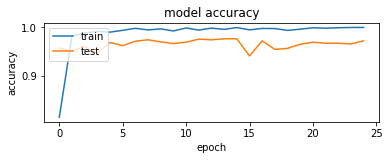

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   


Menampilan hasil loss setiap epochnya

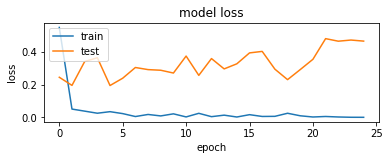

In [ ]:
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

Melakukan evaluasi model dengan menggunakan confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
print("====Laporan Hasil Menggunakan CNN====")
print("Confusion Matrix:")
y_pred=model.predict(x_valid)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_vaild,axis=1)
print(confusion_matrix(y_true,y_pred_classes))
print()
print(classification_report(y_true,y_pred_classes))
print("Akurasi score:",score[1])

====Laporan Hasil Menggunakan CNN====
Confusion Matrix:
[[ 87   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  72   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  70   0   0   4   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  84   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  43  20   0  18   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  90   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  78   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  73   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  79   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  73   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  70   0   0   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0   0  81   0   0   0   0]
 [  0   0   0   0   0